## 1. Carga y Pre-Proceso de Datos

Descarga por favor el .zip 

cats_and_dogs_filtered.zip

del Blackboard de la tarea en la misma ruta (carpeta) de este notebook y ejecuta los siguientes pasos.

(o si usas Google Colab lo tienes en la dirección anterior)

Mantengo la nota original del origen del dataset.


**NOTE:** The 2,000 images used in this exercise are excerpted from the ["Dogs vs. Cats" dataset](https://www.kaggle.com/c/dogs-vs-cats/data) available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

In [1]:
import os
import zipfile

local_zip = './dataset_tarea_1_2023.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

The contents of the .zip are extracted to the base directory `cats_and_dogs_filtered`, which contains `train` and `validation` subdirectories for the training and validation datasets (see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/validation/check-your-intuition) for a refresher on training, validation, and test sets), which in turn each contain `cats` and `dogs` subdirectories. 

NOTA: Además, en el mismo directorio donde se descomprime el cats_and_dogs_filtered descomprime el test.zip en un directorio test. 

Si todo está bien nombrado y "colgando" de la misma ruta, te saldrán los siguientes tamaños de conjuntos train     /validation / test (un poco más adelante)

- total training cat images: 1000
- total training dog images: 1000
- total validation cat images: 500
- total validation dog images: 500
- total test cat images: 155
- total test dog images: 158



In [2]:
base_dir = './dataset_tarea_1_2023'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Directory with our test cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')

# Directory with our test dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')

Now, let's see what the filenames look like in the `cats` and `dogs` `train` directories (file naming conventions are the same in the `validation` directory):

In [3]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.101.jpg', 'cat.102.jpg', 'cat.103.jpg', 'cat.104.jpg', 'cat.105.jpg', 'cat.106.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's find out the total number of cat and dog images in the `train` and `validation` directories:

In [4]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 461
total test dog images: 277


For both cats and dogs, we have 1,000 training images and 500 test images.

Now let's take a look at a few pictures to get a better sense of what the cat and dog datasets look like. First, configure the matplot parameters:

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

Now, display a batch of 8 cat and 8 dog pictures. You can rerun the cell to see a fresh batch each time:

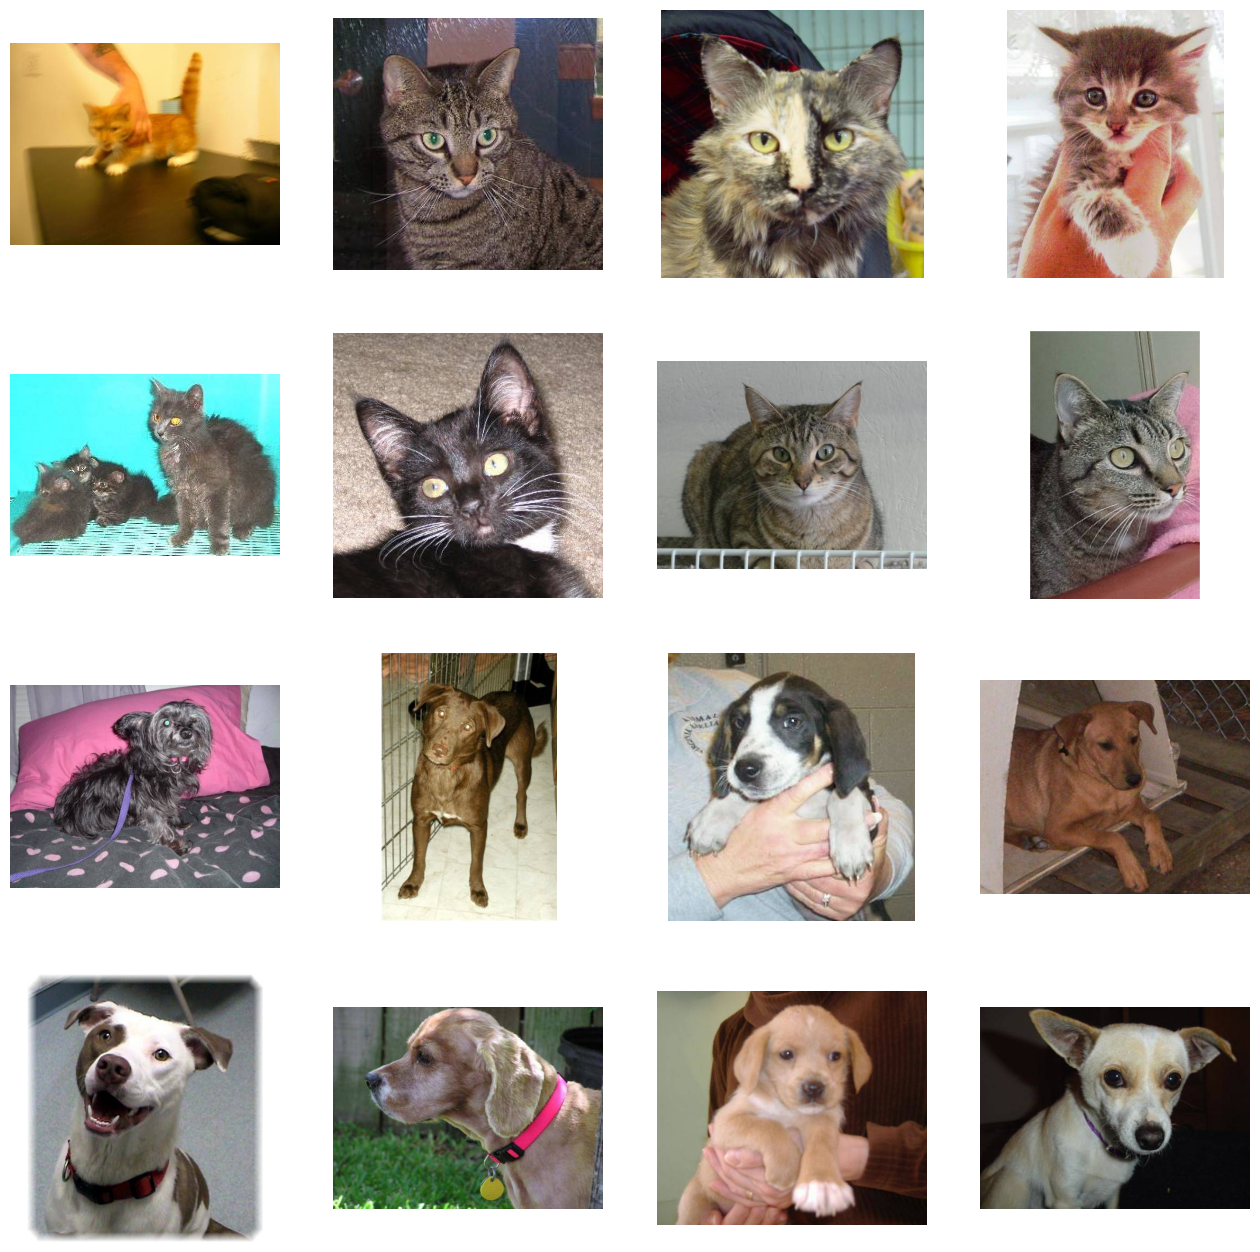

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[pic_index-8:pic_index]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of 20 images of size 150x150 and their labels (binary).

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).

In Keras this can be done via the `keras.preprocessing.image.ImageDataGenerator` class using the `rescale` parameter. This `ImageDataGenerator` class allows you to instantiate generators of augmented image batches (and their labels) via `.flow(data, labels)` or `.flow_from_directory(directory)`. These generators can then be used with the Keras model methods that accept data generators as inputs: `fit_generator`, `evaluate_generator`, and `predict_generator`.

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

base_dir = './dataset_tarea_1_2023'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')


# Flow training images in batches of 20 using train_datagen generator
train_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)


# Flow training images in batches of 20 using train_datagen generator
validation_generator = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)

# Flow training images in batches of 20 using train_datagen generator
test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False)



Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 738 files belonging to 2 classes.


# 2. Modelo CNN (con summary + compile)

In [8]:
# 2. Modelo CNN (con summary + compile)
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes: cat and dog
])

# Resumen del modelo
model.summary()

# Compilación del modelo
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

# 3. Entrenamiento del modelo (.fit) y rendimiento del modelo (accuracy) con conjunto test

In [9]:
import datetime
#PARA TENSORBOARD

#%tensorboard --reload_interval
#%tensorboard --reload_multifile True
#%reload_ext tensorboard 

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)



# 3. Entrenamiento del modelo (.fit) y rendimiento del modelo (accuracy) con conjunto test
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,  # Puedes ajustar el número de épocas según sea necesario
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[tensorboard_callback] #callback al TENSORBOARD
)

# Evaluación del modelo con el conjunto de prueba
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")



Epoch 1/100
63/63 [==============================] - 180s 3s/step - loss: 428.7042 - accuracy: 0.5520 - val_loss: 0.7205 - val_accuracy: 0.5880
Epoch 2/100
63/63 [==============================] - 117s 2s/step - loss: 31.4336 - accuracy: 0.6065 - val_loss: 0.6868 - val_accuracy: 0.5510
Epoch 3/100
63/63 [==============================] - 116s 2s/step - loss: 35.4358 - accuracy: 0.5475 - val_loss: 1.3228 - val_accuracy: 0.4980
Epoch 4/100
63/63 [==============================] - 145s 2s/step - loss: 0.8000 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/100
63/63 [==============================] - 119s 2s/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/100
17/63 [=======>......................] - ETA: 1:03 - loss: 2.7029 - accuracy: 0.5184

KeyboardInterrupt: 

In [ ]:
#%tensorboard --reload_multifile True
#%reload_ext tensorboard
#abrir una consola en env y ejecutar el siguiente codigo sin host
#%tensorboard --logdir logs/fit --host localhost


# 4. Trabajo adicional (Neural Transfer, Fine Tuning, visualización de capas intermedias ...)

1/1 [==============================] - 0s 69ms/step


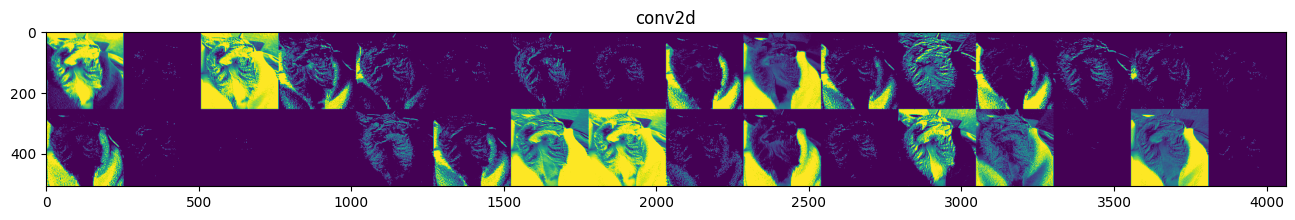

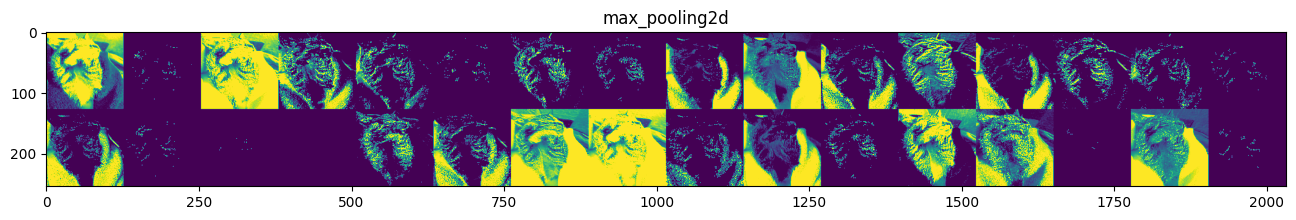

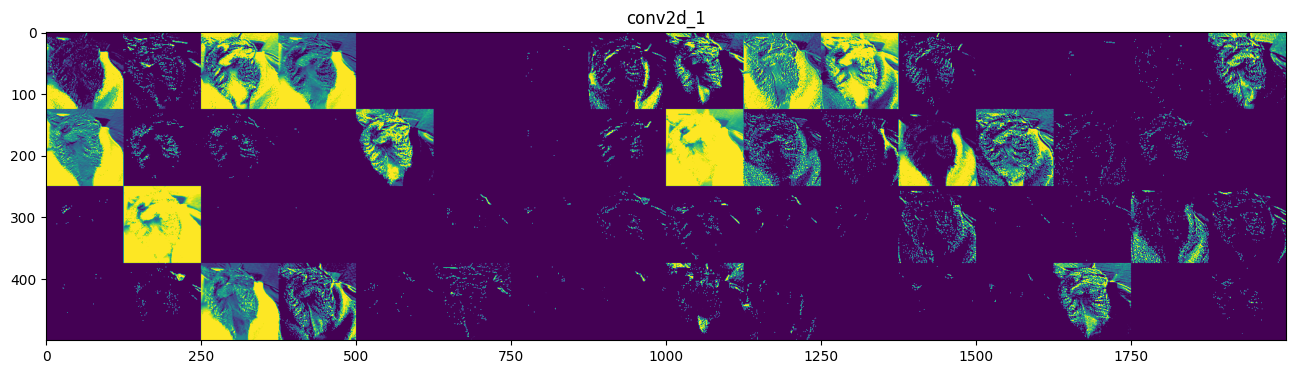

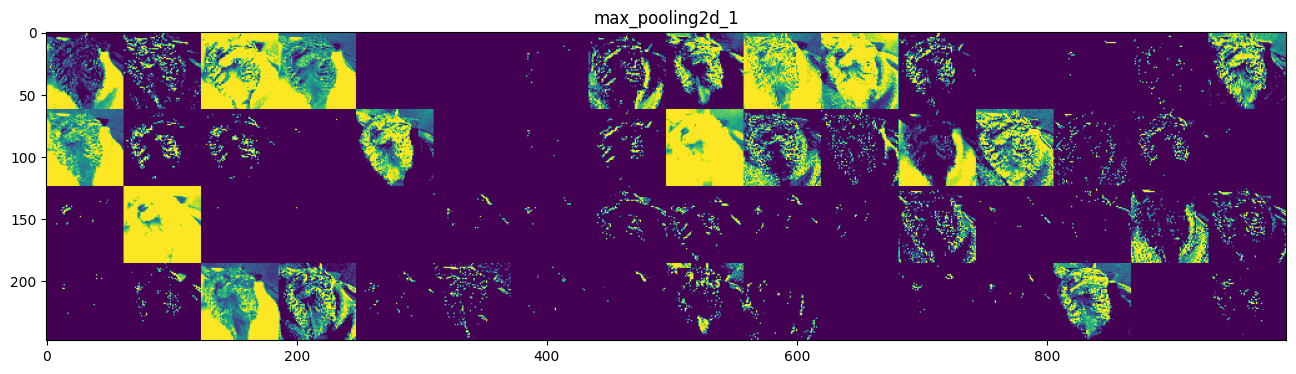

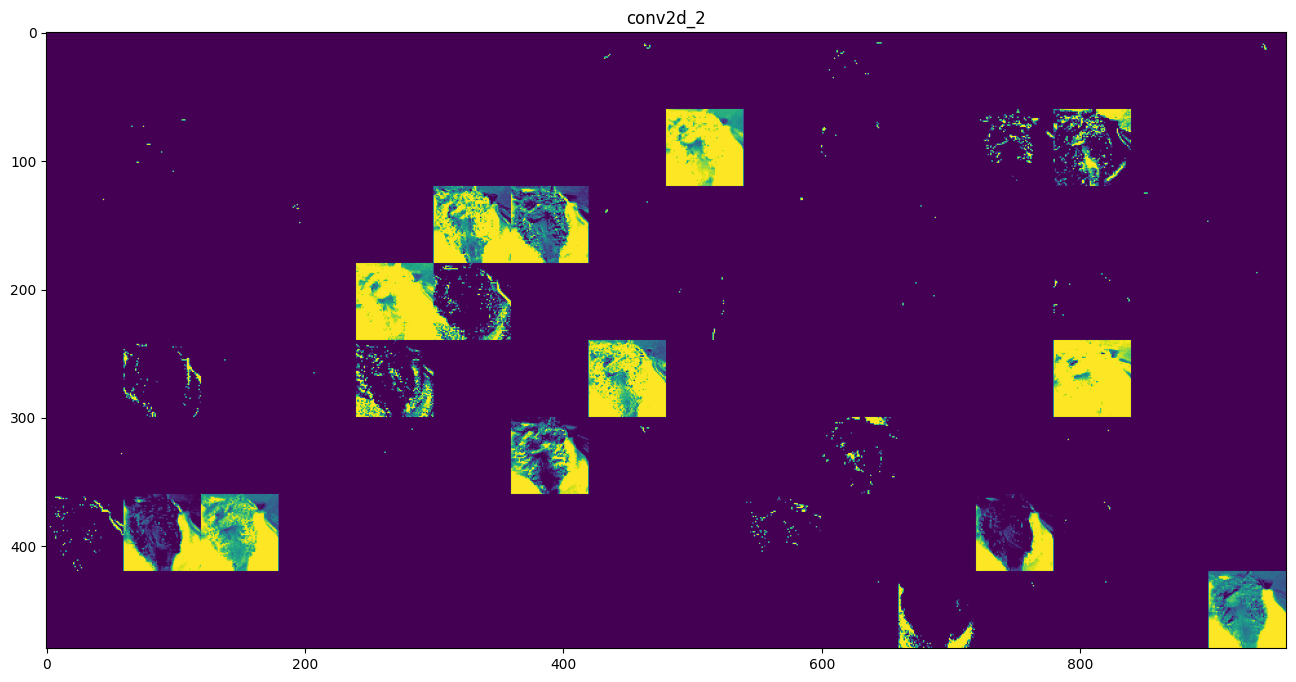

In [11]:
# 4. Trabajo adicional (Neural Transfer, Fine Tuning, visualización de capas intermedias ...)
# Aquí puedes agregar cualquier trabajo adicional que desees realizar, como la implementación de Fine Tuning,
# Neural Transfer, o visualización de capas intermedias.
# Por ejemplo, para visualizar capas intermedias puedes hacer lo siguiente:
from tensorflow.keras.models import Model

import numpy as np  # Add this import
import matplotlib.pyplot as plt  # Add this import

# Define un nuevo modelo que toma como entrada las imágenes originales
# y produce las activaciones de las capas intermedias que te interesan
layer_outputs = [layer.output for layer in model.layers[:5]]  # Cambia [:5] por las capas que quieras visualizar
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Selecciona una imagen de prueba
img_path = 'C:/Users/alvar/AppData/Local/Programs/Python/Python311/IA/practica/dataset_tarea_1_2023/test/cats/Foto29.jpeg'  # Cambia esto con la ruta de una imagen de prueba
img = tf.keras.utils.load_img(img_path, target_size=(256, 256))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

# Obtiene las activaciones de las capas intermedias para la imagen de prueba
activations = activation_model.predict(img_array)

# Visualiza las activaciones
layer_names = [layer.name for layer in model.layers[:5]]  # Cambia [:5] por las capas que hayas seleccionado
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]

            # Check for zero standard deviation
            if channel_image.std() != 0:
                channel_image /= channel_image.std()

            # Check for NaN values and replace them with zeros
            channel_image = np.nan_to_num(channel_image)

            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')



In [ ]:
#5 ES UN GATO O UN PERRO?

1/1 [==============================] - 0s 114ms/step
Prediction: Dog


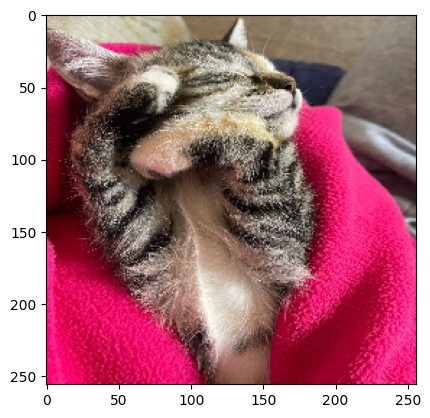

In [12]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Carga la imagen de prueba
img_path = 'C:/Users/alvar/AppData/Local/Programs/Python/Python311/IA/practica/dataset_tarea_1_2023/test/cats/Foto29.jpeg'
img = image.load_img(img_path, target_size=(256, 256))

# Convierte la imagen a un arreglo numpy y realiza preprocesamiento
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Realiza la predicción con el modelo original
predictions = model.predict(img_array)

# Convierte las probabilidades a una etiqueta (gato o perro)
label = "Cat" if predictions[0][0] > 0.5 else "Dog"

# Muestra la predicción
print(f"Prediction: {label}")

# Muestra la imagen
plt.imshow(img)
plt.show()
